### 2. Importación de librerías

In [ ]:
# Librerías esenciales para manipulación de datos y sistema
import os
import numpy as np
import pandas as pd
from pathlib import Path

# Librerías para manejo y visualización de imágenes
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para Deep Learning (usaremos Keras + TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# Librerías para métricas y evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Ignorar advertencias innecesarias
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo visual para gráficas
sns.set(style="whitegrid")


🧠 Comentarios de Aprendizaje-Comprensión 🟦🟦🟦🟦🟦🟦🟦🟦
<hr>

- Las librerías servirán tanto para modelos de CNN básica (desde cero) como transfer learning (VGG16, ResNet50) (esto son modelos pre-entrenados)

- las librerías preparan todo para aumento de datos ( técnicas que se utilizan para aumentar artificialmente el tamaño de un conjunto de datos de entrenamiento), callbacks y evaluación de desempeño clínico (matriz de confusión, ROC, AUC...).

- `import cv2` es clave para previsualizar o ajustar contraste en imágenes .png o .jpg

### 3. Carga y Exploración del Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ruta del dataset que monté en drive
#Este dataset contiene las imágenes compartidas por profe + clasificadas manual de G1020
import os

ruta_base = '/content/drive/MyDrive/glaucoma_proyecto'

glaucoma_path = os.path.join(ruta_base, 'glaucoma')
normal_path = os.path.join(ruta_base, 'normal')

print(f"🧿 Imágenes con glaucoma: {len(os.listdir(glaucoma_path))}")
print(f"👁️ Imágenes normales: {len(os.listdir(normal_path))}")


🧿 Imágenes con glaucoma: 234
👁️ Imágenes normales: 442


**Visualización de imágenes ejemplo**

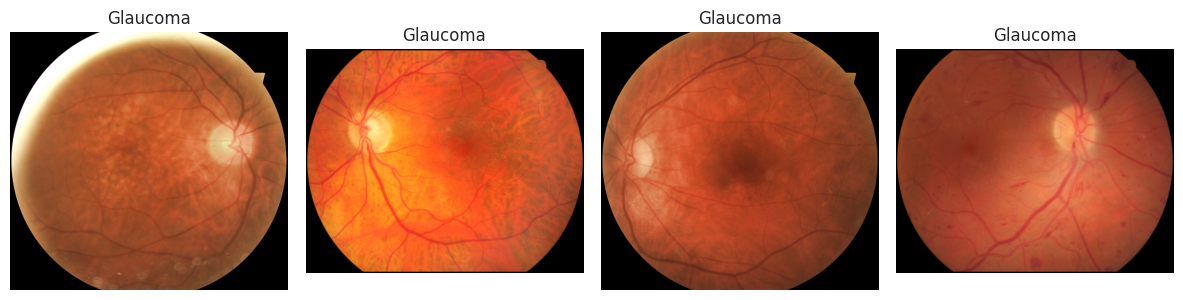

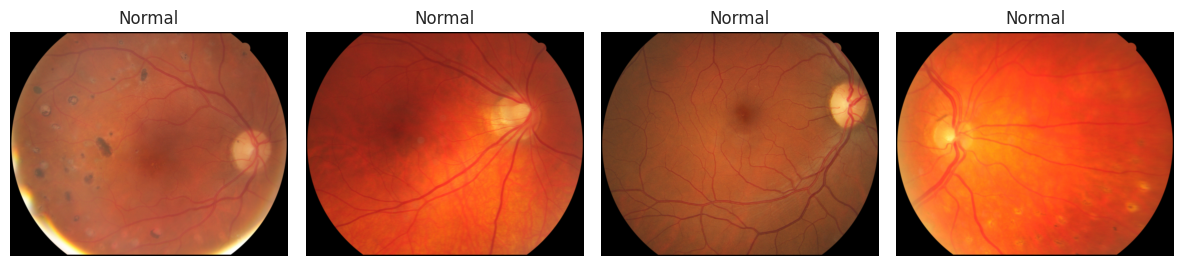

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

def mostrar_ejemplos(path, titulo, cantidad=4):
    imagenes = random.sample(os.listdir(path), cantidad)
    plt.figure(figsize=(12, 4))
    for i, img_name in enumerate(imagenes):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, cantidad, i+1)
        plt.imshow(img)
        plt.title(f"{titulo}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos
mostrar_ejemplos(glaucoma_path, "Glaucoma")
mostrar_ejemplos(normal_path, "Normal")


**Ver distribución de clases**

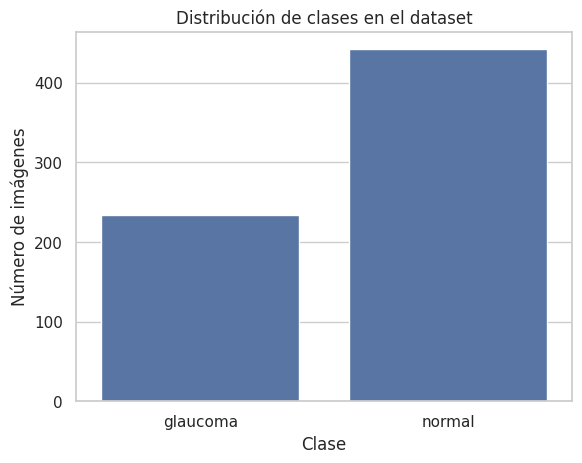

In [ ]:
import pandas as pd
import seaborn as sns

conteo = {
    "glaucoma": len(os.listdir(glaucoma_path)),
    "normal": len(os.listdir(normal_path))
}

df_conteo = pd.DataFrame(list(conteo.items()), columns=["Clase", "Cantidad"])
sns.barplot(x="Clase", y="Cantidad", data=df_conteo)
plt.title("Distribución de clases en el dataset")
plt.ylabel("Número de imágenes")
plt.show()


**El dataset está moderadamente desbalanceado**

- Hay casi el doble de imágenes de ojos normales comparado con los glaucomatosos.

### **4. Prepocesamiento y división de imágenes**

In [ ]:
import os       # Manejo de rutas de carpetas y archivos del sistema
import shutil   # Copiar, mover o eliminar archivos y carpetas
import random   # Selección y orden aleatorio de listas (útil para shuffle)
from PIL import Image  # Librería para manipular imágenes (cargar, guardar, etc.)
from pathlib import Path  # Manejo moderno de rutas (más limpio que os.path)
import cv2      # OpenCV: potente librería para procesamiento de imágenes

# 🔧 Parámetros
IMG_SIZE = 224  # Puedes cambiar a 299, 256, etc.
porcentaje_train = 0.7   # 70% para entrenamiento
porcentaje_val = 0.15    # 15% para validación
porcentaje_test = 0.15   # 15% para test

# 📁 Rutas de origen y destino
origen = "/content/drive/MyDrive/glaucoma_proyecto"
destino = "/content/data"

# 🧹 Limpiar carpeta destino si existe
if os.path.exists(destino):
    shutil.rmtree(destino)

# 🛠️ Función para aplicar CLAHE (opcional, desactivada por defecto)
def aplicar_CLAHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# 🧠 Procesamiento y división
for clase in ['glaucoma', 'normal']:
    ruta_clase = os.path.join(origen, clase)
    imagenes = os.listdir(ruta_clase)
    random.shuffle(imagenes)

    n_total = len(imagenes)
    n_train = int(n_total * porcentaje_train)
    n_val = int(n_total * porcentaje_val)

    divisiones = {
        'train': imagenes[:n_train],
        'val': imagenes[n_train:n_train + n_val],
        'test': imagenes[n_train + n_val:]
    }

    for tipo, lista_imagenes in divisiones.items():
        ruta_destino = Path(destino) / tipo / clase
        ruta_destino.mkdir(parents=True, exist_ok=True)

        contador_total = 0
        imagenes_invalidas = 0

        for img_name in lista_imagenes:
            img_path = os.path.join(ruta_clase, img_name)

            # Leer la imagen
            img = cv2.imread(img_path)
            if img is None:
                imagenes_invalidas += 1
                print(f"⚠️ Imagen inválida o no encontrada: {img_path}")
                continue

            # Convertir a RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Redimensionar
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # (Opcional) aplicar CLAHE #esto ayuda con temas de constraste de las imágenes
            # img = aplicar_CLAHE(img)

            # Guardar imagen preprocesada
            nueva_ruta = os.path.join(ruta_destino, img_name)
            img = Image.fromarray(img)
            img.save(nueva_ruta)

            contador_total += 1

        print(f"✅ Total imágenes copiadas a {tipo}/{clase}: {contador_total}")
        print(f"🧯 Total de imágenes inválidas saltadas en {tipo}/{clase}: {imagenes_invalidas}")


✅ Total imágenes copiadas a train/glaucoma: 163
🧯 Total de imágenes inválidas saltadas en train/glaucoma: 0
✅ Total imágenes copiadas a val/glaucoma: 35
🧯 Total de imágenes inválidas saltadas en val/glaucoma: 0
✅ Total imágenes copiadas a test/glaucoma: 36
🧯 Total de imágenes inválidas saltadas en test/glaucoma: 0
✅ Total imágenes copiadas a train/normal: 309
🧯 Total de imágenes inválidas saltadas en train/normal: 0
✅ Total imágenes copiadas a val/normal: 66
🧯 Total de imágenes inválidas saltadas en val/normal: 0
✅ Total imágenes copiadas a test/normal: 67
🧯 Total de imágenes inválidas saltadas en test/normal: 0


### **5. Aumento de datos (Data Augmentation)**

El aumento de datos o Data Augmentation consiste en crear versiones modificadas de las imágenes originales (rotadas, volteadas, con zoom, etc.), esto nos ayuda a:

- Aumentar el tamaño efectivo del dataset

- Simular variabilidad real de los pacientes (como distinta posición de la cabeza o iluminación)

- Reducir el overfitting

- Mejorar la capacidad del modelo para generalizar

La implementación se hará con `ImageDataGenerator` de Keras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🧪 Generador con aumentos solo para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # rotaciones aleatorias
    width_shift_range=0.1,    # desplazamiento horizontal
    height_shift_range=0.1,   # desplazamiento vertical
    zoom_range=0.1,           # pequeño zoom
    horizontal_flip=True,     # voltear horizontalmente
    fill_mode='nearest'       # cómo rellenar los píxeles vacíos
)

# 📏 Generadores para validación y test (sin aumentos)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 📂 Rutas
ruta_train = '/content/data/train'
ruta_val = '/content/data/val'
ruta_test = '/content/data/test'

# 🚀 Cargar imágenes desde carpetas
train_generator = train_datagen.flow_from_directory(
    ruta_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    ruta_val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    ruta_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # importante si usas predicciones y métricas
)


Found 472 images belonging to 2 classes.
Found 101 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


## **6. Diseño del Modelo CNN (desde cero)**

**1. Arquitectura del modelo**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# 🔨 Construcción de la CNN desde cero
modelo_cnn = Sequential()

# 🔹 Primer bloque convolucional
modelo_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
modelo_cnn.add(MaxPooling2D(pool_size=(2, 2)))
modelo_cnn.add(BatchNormalization())

# 🔹 Segundo bloque convolucional
modelo_cnn.add(Conv2D(64, (3, 3), activation='relu'))
modelo_cnn.add(MaxPooling2D(pool_size=(2, 2)))
modelo_cnn.add(BatchNormalization())

# 🔹 Tercer bloque convolucional
modelo_cnn.add(Conv2D(128, (3, 3), activation='relu'))
modelo_cnn.add(MaxPooling2D(pool_size=(2, 2)))
modelo_cnn.add(BatchNormalization())

# 🔹 Capa de flatten y fully connected
modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(128, activation='relu'))
modelo_cnn.add(Dropout(0.5))  # Regularización
modelo_cnn.add(Dense(1, activation='sigmoid'))  # Clasificación binaria

# Mostrar resumen del modelo
modelo_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

## 🧠 Arquitectura de la Red Neuronal Convolucional (CNN) :🟦🟦🟦🟦🟦🟦🟦🟦

Diseñamos una CNN desde cero con tres bloques convolucionales, seguidos de capas de normalización, max pooling y finalmente una red completamente conectada (fully connected).

- `Conv2D`: Detecta patrones visuales (bordes, texturas, formas del nervio óptico, etc.)
- `MaxPooling2D`: Reduce el tamaño de la imagen, conservando características clave.
- `BatchNormalization`: Estabiliza y acelera el entrenamiento.
- `Dropout`: Evita el sobreajuste apagando neuronas aleatoriamente.
- `Dense`: Toma las características extraídas y decide si es glaucoma o normal.
- `Sigmoid`: Se usa porque es un problema de clasificación binaria.




**2. Compilación del modelo**

In [ ]:
from tensorflow.keras.optimizers import Adam

modelo_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


**3. Entrenamiento del modelo con callbacks**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 🛑 Parar si el modelo deja de mejorar
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# 💾 Guardar el mejor modelo
mejor_modelo = ModelCheckpoint('mejor_modelo_cnn.h5', save_best_only=True)

# 🚀 Entrenar
historial = modelo_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, mejor_modelo]
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5689 - loss: 1.8539

15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.5698 - loss: 1.8513 - val_accuracy: 0.6535 - val_loss: 0.6675
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5994 - loss: 1.6111

15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.5982 - loss: 1.5972 - val_accuracy: 0.6535 - val_loss: 0.6620
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6293 - loss: 1.1519

15/15 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.6276 - loss: 1.1482 - val_accuracy: 0.6535 - val_loss: 0.6559
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.5893 - loss: 0.8820 - val_accuracy: 0.6535 - val_loss: 0.6584
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.6470 - loss: 0.7407 - val_accuracy: 0.6535 - val_loss: 0.6606
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6372 - loss: 0.8044 - val_accuracy: 0.6535 - val_loss: 0.6604
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6474 - loss: 0.6937 - val_accuracy: 0.6535 - val_loss: 0.6793
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.6604 - loss: 0.6672 - val_accuracy: 0.6535 - val_loss: 0.7163


🧠 Comentarios de Aprendizaje-Comprensión 🟦🟦🟦🟦🟦🟦🟦🟦
<hr>

- Una **época** es una pasada completa por todo el conjunto de entrenamiento.

Ejemplo: tienes 500 imágenes, entonces:

1 epoch = el modelo ve las 500 imágenes una vez

10 epochs = el modelo ve las mismas imágenes 10 veces

Esto permite que el modelo aprenda poco a poco e intente mejorar en cada vuelta

- La métrica de **loss** es la forma en que el modelo se castiga a sí mismo cuando se equivoca.

Es el valor de una función de pérdida (en nuestro caso usamos `binary_crossentropy` porque es clasificación binaria)

Representa cuánto error hay entre la predicción del modelo y la etiqueta real

Cuanto más bajo el loss, mejor va aprendiendo el modelo

**A tener en cuenta:**

🔁 A medida que pasan las épocas:

El loss debería bajar

El accuracy debería subir

Si el val_loss empieza a subir mientras el train_loss baja mucho, puede que el modelo esté sobreajustando (overfitting)



**Visualización de métricas por época (loss y accuracy)**

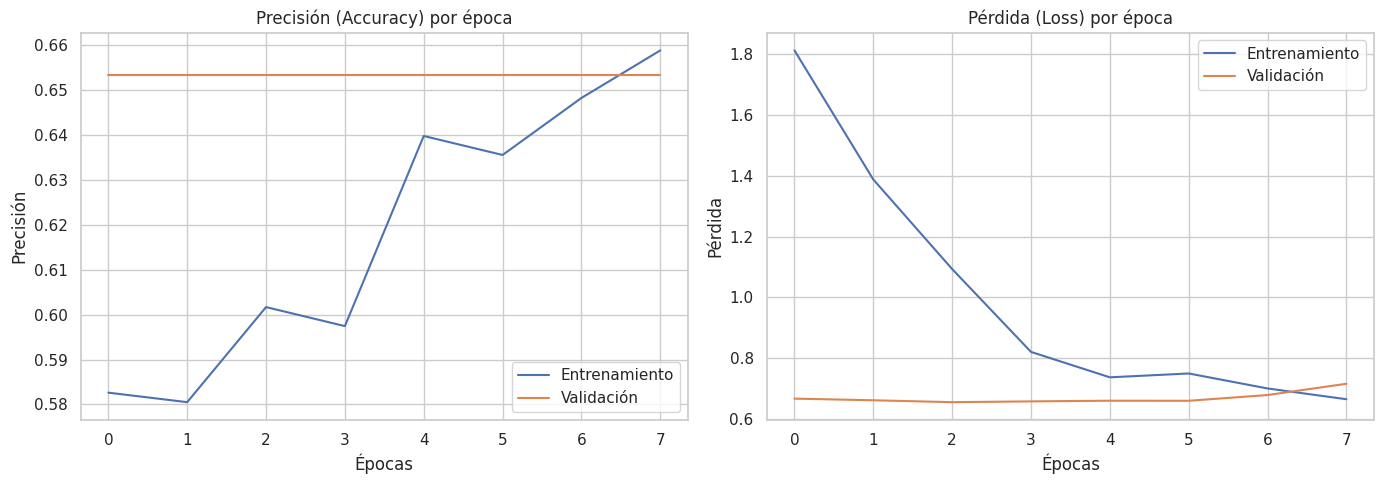

In [ ]:
import matplotlib.pyplot as plt

# Extraer historial
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']
loss = historial.history['loss']
val_loss = historial.history['val_loss']
epochs_range = range(len(acc))

# Crear figura
plt.figure(figsize=(14, 5))

# 📊 Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión (Accuracy) por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.grid(True)

# 📉 Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida (Loss) por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


Interpretación

**Precisión (Accuracy)**

Entrenamiento: llegó hasta 0.6604

Validación: se mantuvo constante en 0.6535

La diferencia es mínima (~0.007) lo cual es una muy buena señal

El modelo no está sobreajustando ni subajustando

**Conclusión:** hay un moderado pero buen equilibrio entre entrenamiento y validación, lo que indica que el modelo generaliza decentemente a datos que no ha visto.
<hr>


**Pérdida (Loss)**

El `train_loss` bajó constantemente (es lo que se espera)

El `val_loss` está más plano y al final aumenta un poco

Esto puede indicar que el modelo ya no está aprendiendo mucho más, y podría beneficiarse de: más datos, un modelo más complejo, o técnicas de regularización (más Dropout o BatchNormalization).

## **7. Evaluación Final**

Esto es para saber qué tan bien nuestro modelo CNN clasifica las imágenes del conjunto de prueba (test)

**Obtener predicciones del modelo**

In [ ]:
# ⚠️ Recordemos: test_generator tiene shuffle=False
y_prob = modelo_cnn.predict(test_generator)
y_pred = (y_prob > 0.5).astype(int).reshape(-1)  # Convertimos a 0 o 1


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


**Obtener etiquetas verdaderas (ground truth)**

In [ ]:
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
print(f"Clases: {class_names}")


Clases: ['glaucoma', 'normal']


**Matriz de confusión + clasificación**

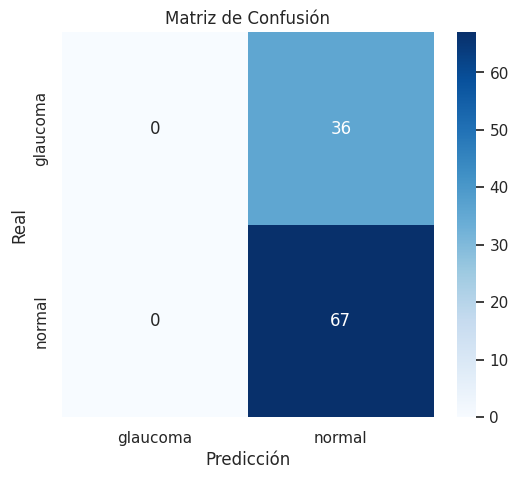

📄 Clasification Report:
              precision    recall  f1-score   support

    glaucoma       0.00      0.00      0.00        36
      normal       0.65      1.00      0.79        67

    accuracy                           0.65       103
   macro avg       0.33      0.50      0.39       103
weighted avg       0.42      0.65      0.51       103



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 📊 Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# 📄 Reporte de clasificación
print("📄 Clasification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


**Curva ROC y AUC**

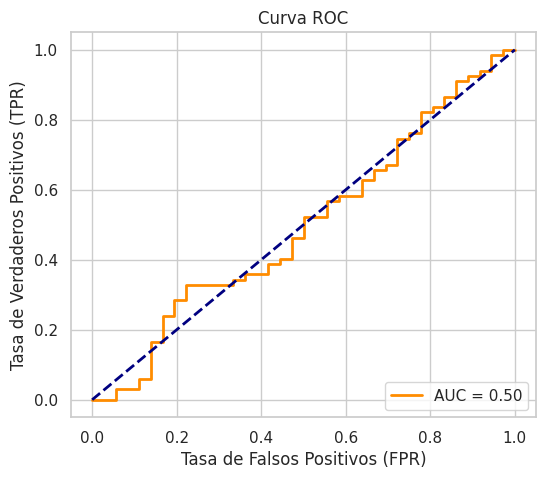

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
